In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

In [2]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [3]:
DIN_acs = "/data/datasets/cruise_data/active/SyncED_Quest/Processed/Step3/"
fn_optics = "quest24_IOP.nc"

In [4]:
# read ACS data
fn_acs = fn_optics
fn_optics
DIN_acs + fn_acs
acs = xr.open_dataset(DIN_acs + fn_acs)
acs.close()

# replace uway_long with uway_lon
if "uway_long" in acs.keys():
    acs.uway_lon = acs.uway_long
    acs = acs.drop(labels="uway_long")

# acs
list(acs.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'acs2_chl',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_cp',
 'acs2_cp_u',
 'acs2_N',
 'ac9_chl',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_cp',
 'ac9_cp_u',
 'ac9_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'ctd_sst',
 'ctd_sal',
 'uway_lat',
 'uway_lon',
 'uway_wind_speed',
 'uway_wind_dir',
 'uway_pressure',
 'uway_humidity',
 'uway_air_temp',
 'uway_dew_temp',
 'uway_chlor',
 'uway_cdom',
 'uway_turb',
 'uway_sst',
 'uway_conductivty',
 'uway_salinity',
 'uway_inlet_temp',
 'uway_trasmittance',
 'uway_oxygen',
 'uway_par']

In [5]:
# manually identify (using plot above) noisy parts of the acx_chl timeseries
#print(' check this manual step for each cruise')
#i2rm = [[5, 10],  # start and end index of noisy period 1 # AMT28
    #    [15, 20], # start and end index of noisy period 2
    #   ]

# i2rm = [] # turned off as default
#plt.figure()
#plt.plot(acs['acs_chl'])

# set values to nan inside the above intervals
#if 'acx_chl' in  acs.keys():
#    for istart,tmp in enumerate(i2rm):
 #           acs['acx_chl'].values[tmp[0]:tmp[1]] = np.nan
 #           acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
  #          acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan

#else:
 #   for istart,tmp in enumerate(i2rm):
  #         acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   #        acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan

In [6]:

#plt.plot(acs.time,acs.uway_lat)


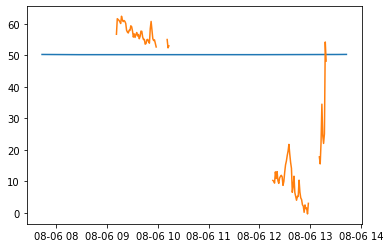

In [7]:
plt.figure()
plt.plot(acs.time,acs.uway_lat)
plt.plot(acs.time,acs.acs_chl*100)

[540 541 542 543 544 545 598 599 600 601 602 603 604 605 606 607 608 609
 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627
 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645
 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663
 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681
 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699
 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717
 718 719 780 781 782 783 784 785 786 787 788 789 790 791 792 793 795 796
 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814
 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832
 833 834 835 836 837 838 839 840 841 842 843 844 845 846 850 851 852 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 877 878 879 880 881 882 883]
[   0    1    2 ... 1437 1438 1439]
[   0    1    2 ... 1437 1438 1439]


(30.0, 38.0)

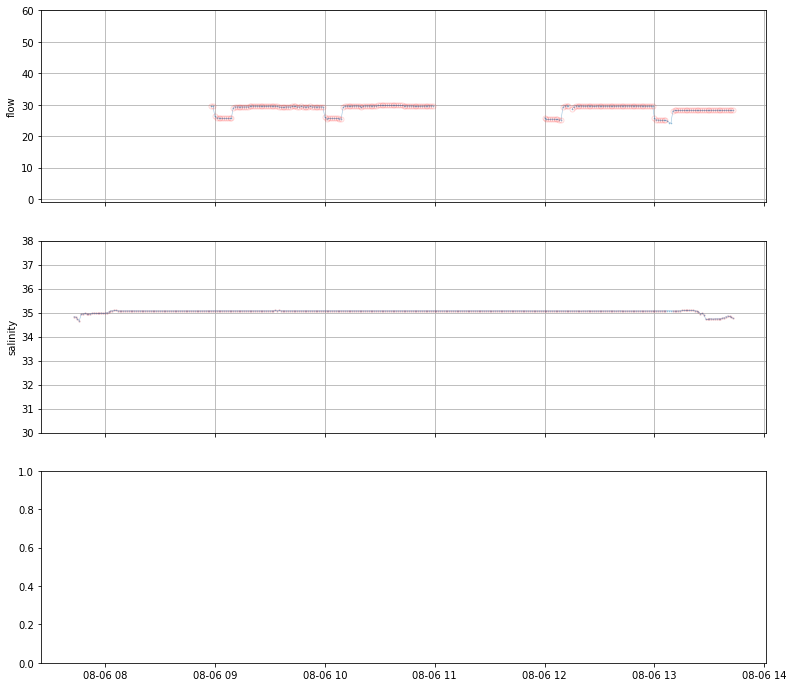

In [8]:
# filter acs data for MQ and noisy events - possibly adjust for quest
MIN_FLOW_RATE = 25
MIN_SAL = 33 

i2f1 = np.where((acs.uway_salinity > MIN_SAL) & (acs.flow > MIN_FLOW_RATE))[0]  
i2f2 = np.where((np.isnan(acs.uway_salinity)==True) | (np.isnan(acs.flow)==True))[0]

i2f = np.union1d(i2f1, i2f2)

print(i2f1)
print(i2f2)
print(i2f)

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])


ax[1].plot(acs.time, acs.uway_salinity, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_salinity[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')
ax[1].set_ylim([30, 38])



Text(0.5, 0, 'Time (UTC)')

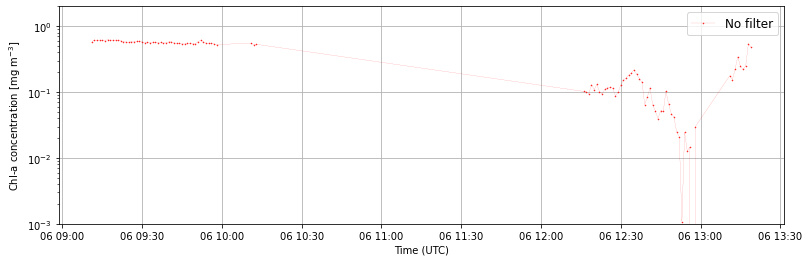

In [9]:
# median filter data
innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
plt.rcParams.update({'font.size': 12})
#MEDFILT_WIN = 31
#ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=1, mfc='none', alpha = 0.5, label='Median filter (30 min window)')
MEDFILT_WIN = 1
ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none', label='No filter')
# ax2.semilogy(acs.time[i2f][innan2], acs.acs2_chl[i2f][innan2], 'k.-', lw=0.1, ms=1, mfc='none')
# ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo',color='orange', lw=1, ms=1, mfc='none', alpha = 0.5, label='ACS2: med filt')
ax2.grid('on')
plt.legend()
plt.ylim([1e-3, 2])
plt.ylabel('Chl-a concentration [mg m$^{-3}$]')
plt.xlabel('Time (UTC)')


In [10]:
# step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=1)# Filter-size set to 1 as default #
# plt.scatter(acs_filtered_xy['acs_chl'].time, acs_filtered_xy['acs_chl'].values)




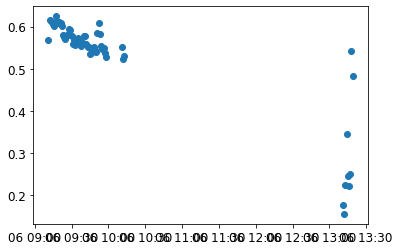

In [11]:
# step y - # filters w.r.t. ap (10th element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)
plt.scatter(acs_filtered_xy['acs_chl'].time, acs_filtered_xy['acs_chl'].values)

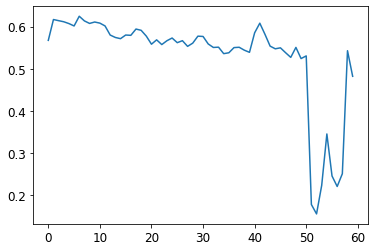

In [12]:

# step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)
plt.plot(acs_filtered_xyz['acs_chl'].values)






Text(0.5, 0, 'Time [UTC]')

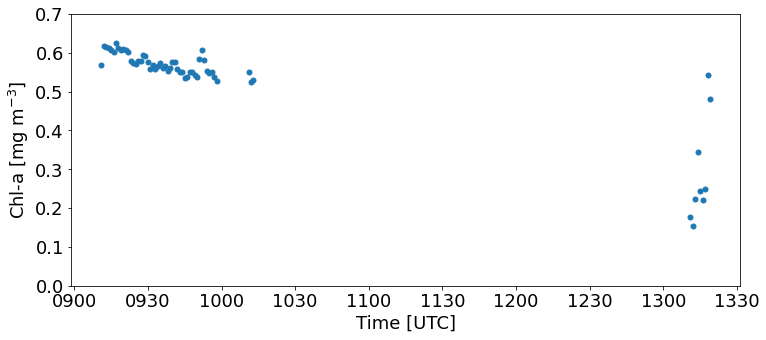

In [30]:
plt.figure(figsize=(12,5))
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 18})
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H%M'))
plt.ylabel('Chl-a [mg m$^{-3}]$')
#plt.plot_date(acs_filtered_x['acs_chl'].time, acs_filtered_x['acs_chl'].values, ms=5, label = 'Failed QC')
plt.plot_date(acs_filtered_xyz['acs_chl'].time, acs_filtered_xyz['acs_chl'].values, ms=5, label = 'Passed QC')
plt.ylim(0,0.7)
plt.xlim()
plt.xlabel('Time [UTC]')

Text(0.5, 0, 'Time [UTC]')

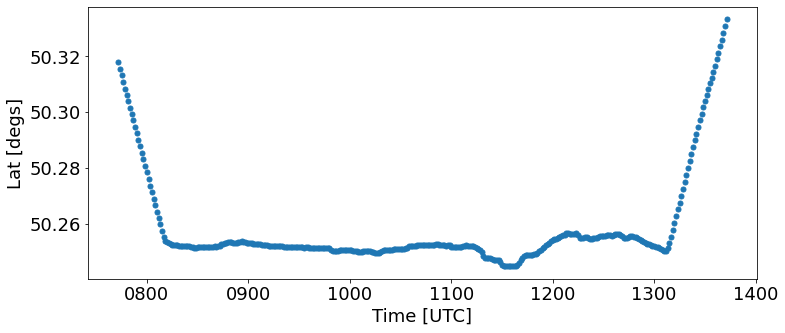

In [33]:
plt.figure(figsize=(12,5))
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 18})
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H%M'))
plt.ylabel('Lat [degs]')
plt.plot_date(acs.time, acs.uway_lat, ms=5, label = 'Passed QC')
plt.xlabel('Time [UTC]')

In [34]:
 acs_filtered_xyz.uway_lat

<xarray.DataArray 'uway_lat' (time: 60)>
array([50.252232, 50.252132, 50.25204 , 50.252016, 50.252024, 50.252052,
       50.252012, 50.251848, 50.251808, 50.251808, 50.251772, 50.251744,
       50.251716, 50.251676, 50.251652, 50.251628, 50.251608, 50.251604,
       50.251608, 50.251608, 50.251572, 50.251516, 50.251432, 50.251608,
       50.251448, 50.251276, 50.251212, 50.25122 , 50.251212, 50.251264,
       50.251416, 50.251376, 50.25132 , 50.251344, 50.25132 , 50.25132 ,
       50.25132 , 50.251156, 50.250652, 50.250344, 50.25022 , 50.250196,
       50.25028 , 50.25044 , 50.250552, 50.25056 , 50.250588, 50.250488,
       50.250136, 50.250024, 50.249856, 50.257624, 50.260172, 50.262616,
       50.265088, 50.267512, 50.270004, 50.272468, 50.274952, 50.2774  ])
Coordinates:
  * time     (time) datetime64[ns] 2024-08-06T09:11:00.000000768 ... 2024-08-...
Attributes:
    units:    degrees_N

In [37]:
# manual clean up of keys
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_N')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_ap')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_ap_u')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_bp')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_bp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_chl')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_cp')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_cp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_wv')

acs_filtered_xyz = acs_filtered_xyz.drop('acs2_N')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_ap')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_ap_u')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_bp')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_bp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_chl')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_cp')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_cp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_wv')

In [38]:
acs_filtered_xyz.to_netcdf(DIN_acs + fn_acs[:-3] + '_QC.nc')
acs_filtered_xyz.close()

In [40]:
list(acs_filtered_xyz.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'ctd_sst',
 'ctd_sal',
 'uway_lat',
 'uway_lon',
 'uway_wind_speed',
 'uway_wind_dir',
 'uway_pressure',
 'uway_humidity',
 'uway_air_temp',
 'uway_dew_temp',
 'uway_chlor',
 'uway_cdom',
 'uway_turb',
 'uway_sst',
 'uway_conductivty',
 'uway_salinity',
 'uway_inlet_temp',
 'uway_trasmittance',
 'uway_oxygen',
 'uway_par']

In [41]:
print(acs_filtered_xyz['acs_chl'].time)


<xarray.DataArray 'time' (time: 60)>
array(['2024-08-06T09:11:00.000000768', '2024-08-06T09:12:00.000007424',
       '2024-08-06T09:13:00.000003840', '2024-08-06T09:14:00.000000256',
       '2024-08-06T09:15:00.000006656', '2024-08-06T09:16:00.000003072',
       '2024-08-06T09:16:59.999999488', '2024-08-06T09:18:00.000006144',
       '2024-08-06T09:19:00.000002560', '2024-08-06T09:19:59.999998976',
       '2024-08-06T09:21:00.000005376', '2024-08-06T09:22:00.000001792',
       '2024-08-06T09:23:00.000008192', '2024-08-06T09:24:00.000004608',
       '2024-08-06T09:25:00.000001024', '2024-08-06T09:26:00.000007680',
       '2024-08-06T09:27:00.000004096', '2024-08-06T09:28:00.000000512',
       '2024-08-06T09:29:00.000006912', '2024-08-06T09:30:00.000003328',
       '2024-08-06T09:30:59.999999744', '2024-08-06T09:32:00.000006144',
       '2024-08-06T09:33:00.000002560', '2024-08-06T09:33:59.999999232',
       '2024-08-06T09:35:00.000005632', '2024-08-06T09:36:00.000002048',
       '2024-0